This notebooks shows active design using simple example based on the Bayesian optimization. The goal is to actively sample a `design space` such that we minimize a user-defined `score`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import head
import numpy as np
import matplotlib.pyplot as plt

In [3]:
npzfile = np.load('../data/exampleUVVis.npz')
grid = npzfile['arr_0']
signals = npzfile['arr_1']
wav = npzfile['arr_2']
print(grid.shape, signals.shape, wav.shape)

(7, 3) (7, 45) (45,)


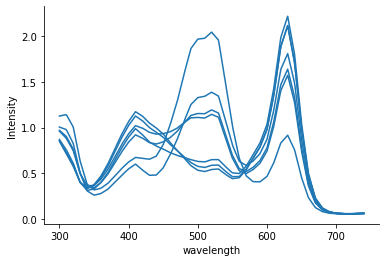

In [4]:
data = head.UVVis(wav, signals)
type(data)
data.plot()
data.decorate()

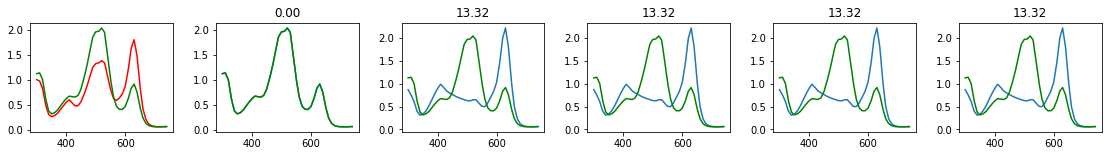

In [5]:
from modAL.models import BayesianOptimizer
import modAL
from skfda.misc.metrics import LpDistance
from sklearn.gaussian_process import GaussianProcessRegressor
from modAL.acquisition import max_EI

regressor = GaussianProcessRegressor()

def distance(query, target):
    d = LpDistance(p=2)
    
    return d(query, target)

x0 = grid[0,:]
s0 = data.fd[0]
st = data.fd[-1]
y0 = distance(s0, st)

optimizer = BayesianOptimizer(
    estimator=regressor,
    X_training=x0.reshape(1, -1), y_training=y0,
    query_strategy=max_EI
)

# Bayesian optimization
loss_evol = []
loss_evol.append(y0)
fig, axs = plt.subplots(1,6,figsize=(2*6*1.6,2))
fig.subplots_adjust(wspace=0.3)
s0.plot(axs[0], color='red', label='initial')
st.plot(axs[0], color='green', label='target')

for n_query in range(5):
    ax = axs[n_query+1]
    query_idx, query_inst = optimizer.query(grid)
    
    si = data.fd[query_idx]
    si.plot(ax, label='current selection')
    st.plot(ax, color='green')

    yi = distance(si, st)
    ax.set_title('{:.2f}'.format(yi[0]))
    loss_evol.append(yi)
    
    xi = grid[query_idx,:]
    
    optimizer.teach(xi.reshape(1, -1), yi)
